# Actividad 6: Pronóstico de series de tiempo

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import acf, pacf
import pandas.util.testing as tm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

<ipython-input-1-c06bdff3bda8>:10: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
url="https://raw.githubusercontent.com/Carlos8abl/F-sica-Computacional-1/main/Actividad%201/Climatolog%C3%ADaDiaria26160.txt"
my_cols = ['Fecha', 'Precip', 'Evap', 'Tmax', 'Tmin']
df_dist = pd.read_csv(url, names=my_cols, encoding='cp1251', sep='\s+', header=None, skiprows=19, skipfooter=1, engine='python')
df_work0 = df_dist.copy()
str_Nulo = 'Nulo'
df_work1 = df_work0.replace(to_replace=str_Nulo, value='', regex=True)
cols_list = ['Precip', 'Evap', 'Tmax', 'Tmin']
for cols in cols_list:
  df_work1[cols] = pd.to_numeric(df_work1[cols], errors='coerce')
df_work2 = df_work1.copy()
df_work2['Fecha']=pd.to_datetime(df_work2['Fecha'], dayfirst=True).copy()
df_work2['Año'] = df_work2['Fecha'].dt.year
df_work2['Mes'] = df_work2['Fecha'].dt.strftime('%b')
df_meteo = df_work2.copy()
df_meteo_ts = df_meteo.copy()
df_meteo_ts = df_meteo_ts.set_index('Fecha')
df_meteo_ts.info()
df_30 = df_meteo_ts[(df_meteo_ts['Año'] >= 1930) & (df_meteo_ts['Año'] < 1960)]
df_60 = df_meteo_ts[(df_meteo_ts['Año'] >= 1960) & (df_meteo_ts['Año'] < 1990)]
df_90 = df_meteo_ts[(df_meteo_ts['Año'] >= 1990) & (df_meteo_ts['Año'] < 2018)]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14263 entries, 1969-01-02 to 2016-04-30
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Precip  14184 non-null  float64
 1   Evap    2899 non-null   float64
 2   Tmax    14094 non-null  float64
 3   Tmin    14096 non-null  float64
 4   Año     14263 non-null  int64  
 5   Mes     14263 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 780.0+ KB


In [3]:
def test_stationarity(df_ts):
    
    rolmean = df_ts.rolling(window=365, center=True).mean()
    rolstd = df_ts.rolling(window=365, center=True).std() 
    
    plt.rcParams["figure.figsize"] = (12,6)
    
    plt.plot(df_ts, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')
 
    plt.legend(loc='best')
    plt.title('Promedio Móvil y Desviación Estándar')
    plt.grid()
    plt.show()
 
    print('Resultados de la Prueba de Dickey-Fuller:')
    dftest = adfuller(df_ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [8]:
start, end = '1994-01', '1998-01'

ts_90 = df_90.loc[start:end].copy()
ts_90.head()

,Precip,Evap,Tmax,Tmin,Año,Mes
Fecha,,,,,,
1994-01-01,0.0,NaN,23.0,4.0,1994,Jan
1994-01-02,0.0,NaN,26.0,4.0,1994,Jan
1994-01-03,0.0,NaN,27.0,2.0,1994,Jan
1994-01-04,0.0,NaN,27.0,3.0,1994,Jan
1994-01-05,0.0,NaN,25.0,3.0,1994,Jan


In [9]:
ts_90['Tmax'].head()

Fecha
1994-01-01    23.0
1994-01-02    26.0
1994-01-03    27.0
1994-01-04    27.0
1994-01-05    25.0
Name: Tmax, dtype: float64

In [10]:
ts_test = ts_90['Tmax'].copy()

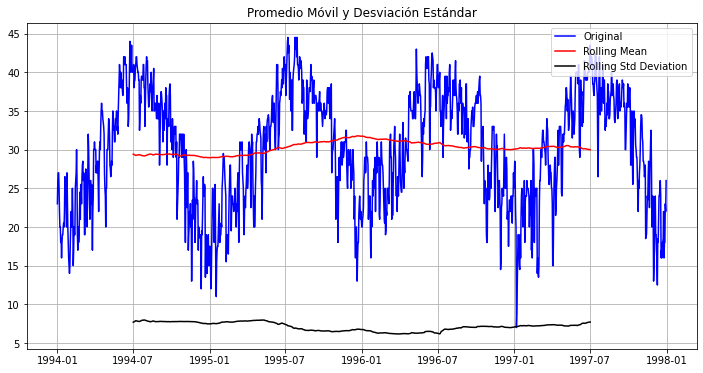

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -2.660008
p-value                           0.081218
#Lags Used                       16.000000
Number of Observations Used    1443.000000
Critical Value (1%)              -3.434890
Critical Value (5%)              -2.863545
Critical Value (10%)             -2.567837
dtype: float64


In [11]:
test_stationarity(ts_test)

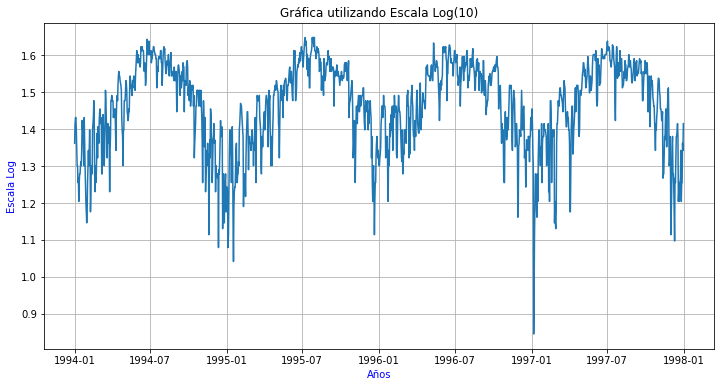

In [12]:
ts_test_log = np.log10(ts_test)
plt.plot(ts_test_log)
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Gráfica utilizando Escala Log(10)')
plt.grid()
plt.show()

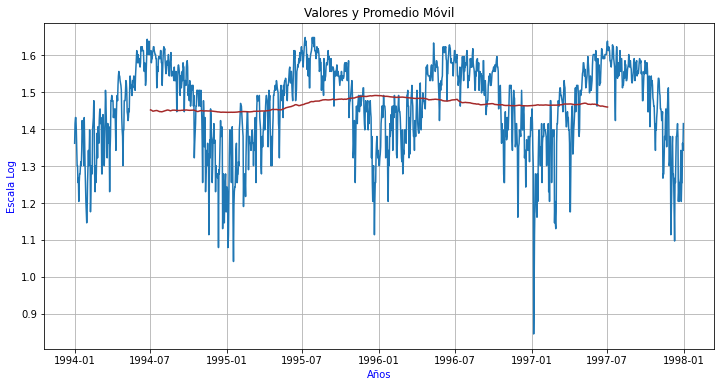

In [13]:
moving_avg = ts_test_log.rolling(365, center=True).mean()
plt.plot(ts_test_log)
plt.plot(moving_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Valores y Promedio Móvil')
plt.grid()
plt.show()

In [14]:
ts_test_log_moving_ave_diff = ts_test_log - moving_avg 
ts_test_log_moving_ave_diff.head()

Fecha
1994-01-01   NaN
1994-01-02   NaN
1994-01-03   NaN
1994-01-04   NaN
1994-01-05   NaN
Name: Tmax, dtype: float64

In [15]:
ts_test_log_moving_ave_diff.dropna(inplace=True)
ts_test_log_moving_ave_diff.head()

Fecha
1994-07-02    0.149946
1994-07-03    0.160995
1994-07-04    0.128466
1994-07-05    0.140333
1994-07-06    0.141298
Name: Tmax, dtype: float64

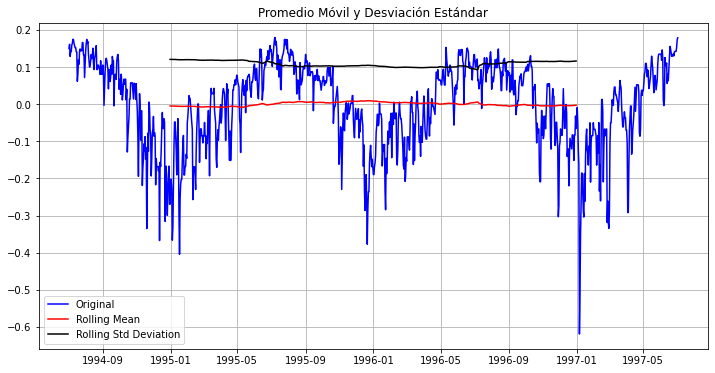

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -2.719836
p-value                           0.070668
#Lags Used                       15.000000
Number of Observations Used    1080.000000
Critical Value (1%)              -3.436419
Critical Value (5%)              -2.864220
Critical Value (10%)             -2.568197
dtype: float64


In [16]:
test_stationarity(ts_test_log_moving_ave_diff)

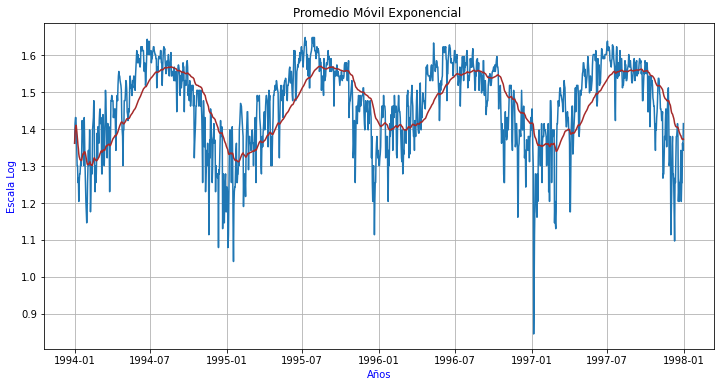

In [17]:
EWM_avg = ts_test_log.ewm(halflife=30).mean()
plt.plot(ts_test_log)
plt.plot(EWM_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Promedio Móvil Exponencial ')
plt.grid()
plt.show()

In [18]:
EWM_avg.head()

Fecha
1994-01-01    1.361728
1994-01-02    1.388658
1994-01-03    1.403223
1994-01-04    1.410504
1994-01-05    1.407874
Name: Tmax, dtype: float64

In [19]:
ts_test_log_EWM_avg_diff = ts_test_log - EWM_avg

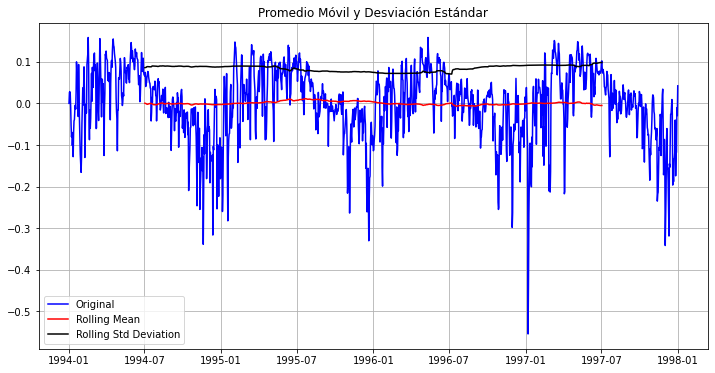

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -3.732916
p-value                           0.003673
#Lags Used                       19.000000
Number of Observations Used    1440.000000
Critical Value (1%)              -3.434899
Critical Value (5%)              -2.863549
Critical Value (10%)             -2.567840
dtype: float64


In [20]:
test_stationarity(ts_test_log_EWM_avg_diff)

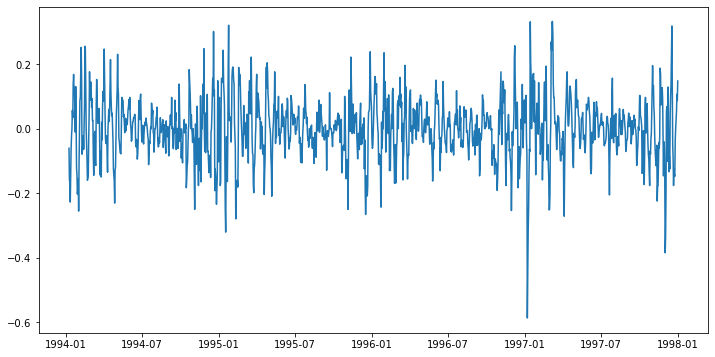

In [22]:
ts_test_log_diff = ts_test_log - ts_test_log.shift(periods=7)
plt.plot(ts_test_log_diff)

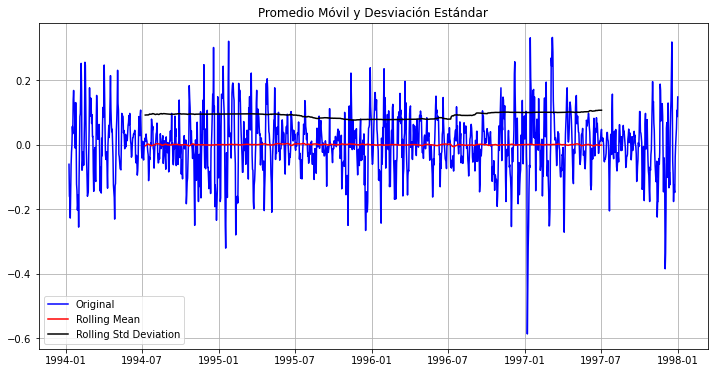

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -8.836711e+00
p-value                        1.711357e-14
#Lags Used                     2.100000e+01
Number of Observations Used    1.431000e+03
Critical Value (1%)           -3.434928e+00
Critical Value (5%)           -2.863562e+00
Critical Value (10%)          -2.567846e+00
dtype: float64


In [23]:
ts_test_log_diff.dropna(inplace=True)
test_stationarity(ts_test_log_diff)

In [24]:
len(ts_test_log_diff)

1453

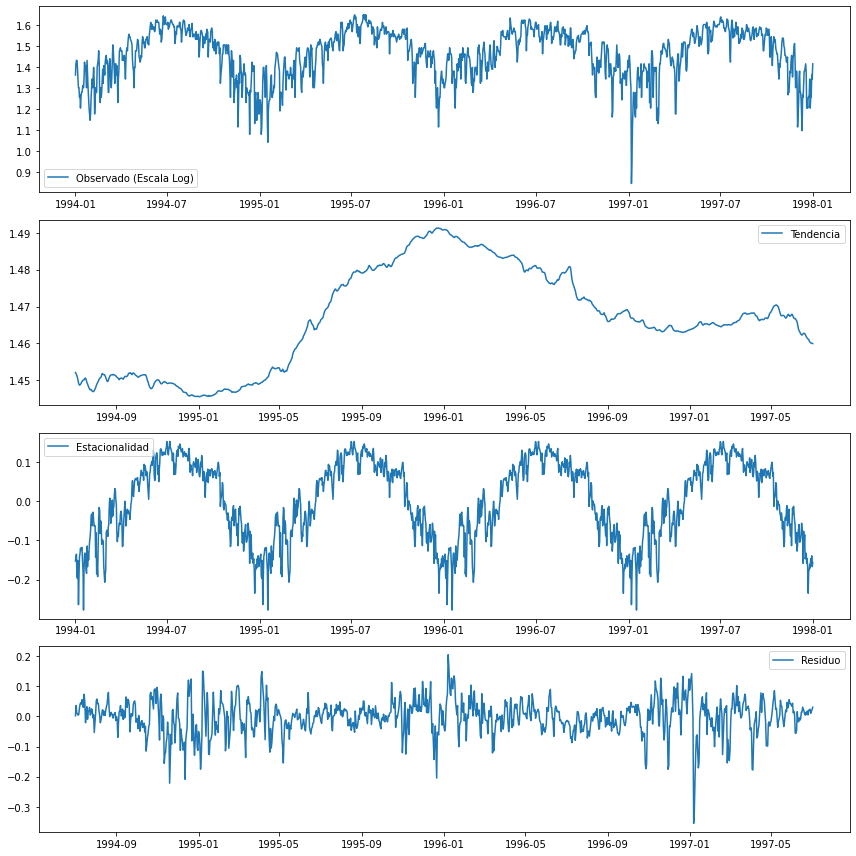

In [25]:
decomposition = sm.tsa.seasonal_decompose(ts_test_log.interpolate(), model='additive', freq=365)

trend = decomposition.trend
seasonal = decomposition.seasonal
residue = decomposition.resid

plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_test_log, label='Observado (Escala Log)')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residue, label='Residuo')
plt.legend(loc='best')
plt.tight_layout()

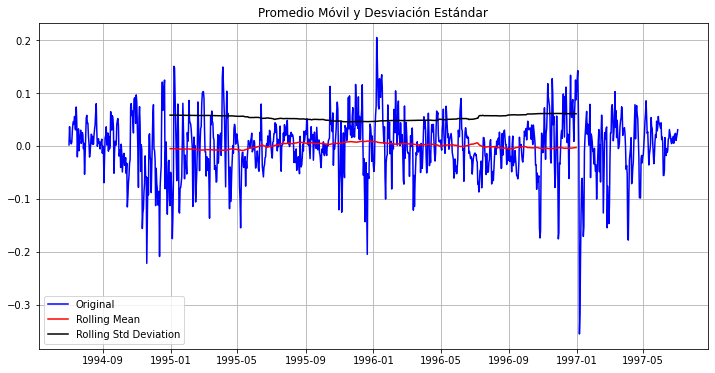

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.012734e+01
p-value                        9.107897e-18
#Lags Used                     1.000000e+01
Number of Observations Used    1.085000e+03
Critical Value (1%)           -3.436391e+00
Critical Value (5%)           -2.864207e+00
Critical Value (10%)          -2.568190e+00
dtype: float64


In [26]:
ts_test_log_decompose = residue 
ts_test_log_decompose.dropna(inplace=True)
test_stationarity(ts_test_log_decompose)

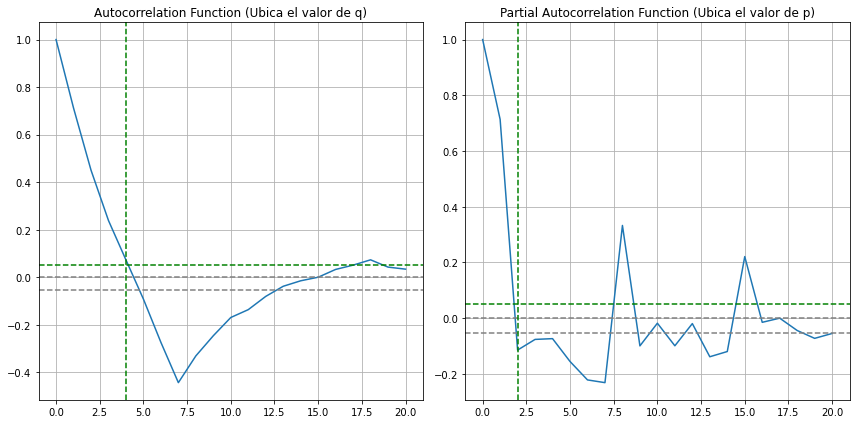

In [27]:
lag_acf = acf(ts_test_log_diff, nlags=20)
lag_pacf = pacf(ts_test_log_diff, nlags=20, method = 'ols')

plt.rcParams["figure.figsize"] = (12,6)

plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')

plt.axvline(x=4, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')

plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

E:\Python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
E:\Python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 1459
Model:                 ARIMA(2, 1, 0)   Log Likelihood                2304.337
Method:                       css-mle   S.D. of innovations              0.050
Date:                Fri, 19 Feb 2021   AIC                          -4600.675
Time:                        22:34:50   BIC                          -4579.533
Sample:                             1   HQIC                         -4592.787
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         2.226e-05      0.001      0.020      0.984      -0.002       0.002
ar.L1.D.Tmax    -0.0746      0.026     -2.870      0.004      -0.126      -0.024
ar.L2.D.Tmax    -0.1268      0.026     -4.88

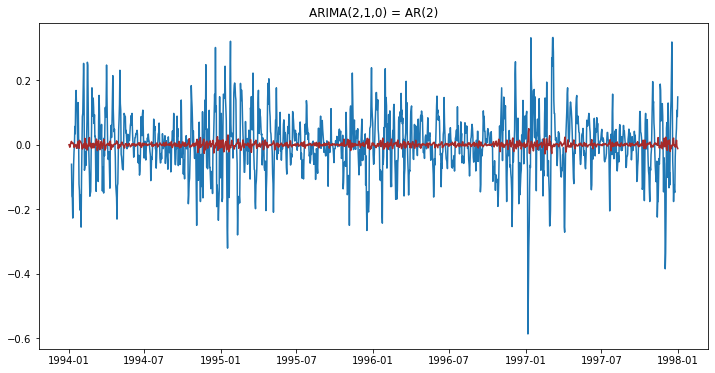

In [28]:
model = ARIMA(ts_test_log, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_AR.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR.summary())

E:\Python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
E:\Python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 1459
Model:                 ARIMA(0, 1, 4)   Log Likelihood                2358.344
Method:                       css-mle   S.D. of innovations              0.048
Date:                Fri, 19 Feb 2021   AIC                          -4704.688
Time:                        22:35:02   BIC                          -4672.975
Sample:                             1   HQIC                         -4692.857
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.751e-05      0.000     -0.050      0.960      -0.001       0.001
ma.L1.D.Tmax    -0.1721      0.026     -6.604      0.000      -0.223      -0.121
ma.L2.D.Tmax    -0.2231      0.025     -8.79

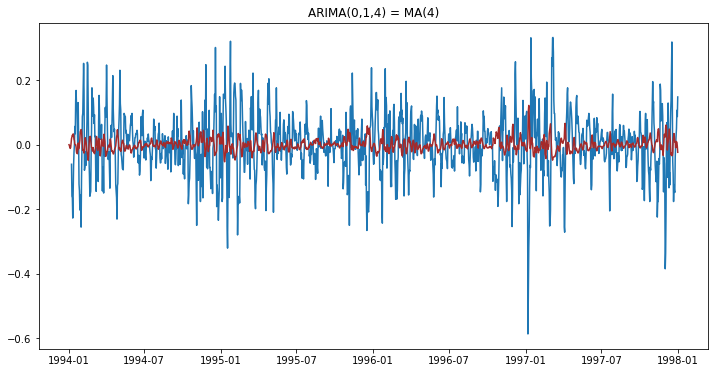

In [29]:
model = ARIMA(ts_test_log, order=(0,1,4), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_MA.fittedvalues, color='brown')
plt.title('ARIMA(0,1,4) = MA(4)')
print(results_MA.summary())

E:\Python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
E:\Python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 1459
Model:                 ARIMA(2, 1, 4)   Log Likelihood                2372.323
Method:                       css-mle   S.D. of innovations              0.048
Date:                Fri, 19 Feb 2021   AIC                          -4728.645
Time:                        22:35:34   BIC                          -4686.361
Sample:                             1   HQIC                         -4712.871
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -7.597e-05      0.001     -0.145      0.884      -0.001       0.001
ar.L1.D.Tmax     1.6545      0.040     41.790      0.000       1.577       1.732
ar.L2.D.Tmax    -0.6624      0.040    -16.66

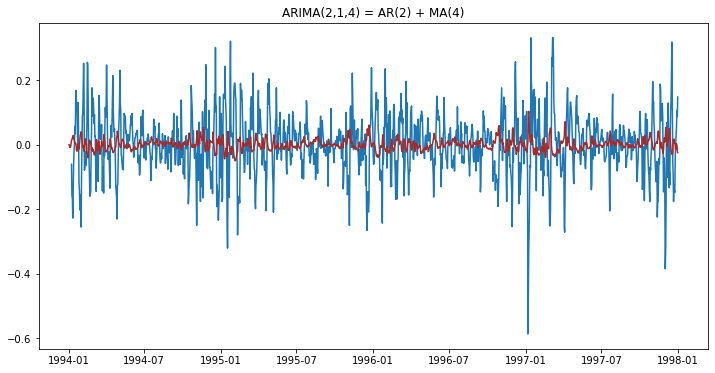

In [30]:
model = ARIMA(ts_test_log, order=(2,1,4), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,4) = AR(2) + MA(4)')
print(results_ARIMA.summary())

In [31]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff)

Fecha
1994-01-02   -0.000076
1994-01-03   -0.003560
1994-01-04   -0.007923
1994-01-05   -0.008893
1994-01-06   -0.004605
                ...   
1997-12-27    0.003638
1997-12-28    0.002065
1997-12-29   -0.000132
1997-12-30   -0.020897
1997-12-31   -0.024644
Length: 1459, dtype: float64


In [32]:
predictions_ARIMA_log = pd.Series(ts_test_log, index = ts_test_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff)
print(predictions_ARIMA_log.head())
print(predictions_ARIMA_log.tail())

Fecha
1994-01-01         NaN
1994-01-02    1.414897
1994-01-03    1.427804
1994-01-04    1.423441
1994-01-05    1.389047
dtype: float64
Fecha
1997-12-27    1.258910
1997-12-28    1.257338
1997-12-29    1.361596
1997-12-30    1.321526
1997-12-31    1.390329
dtype: float64


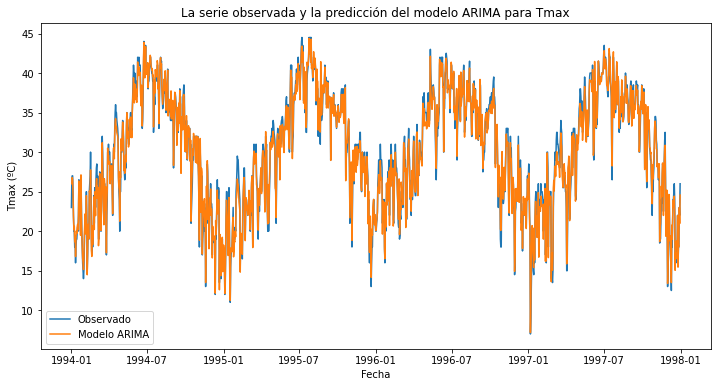

In [33]:
predictions_ARIMA = 10**(predictions_ARIMA_log)

plt.rcParams["figure.figsize"] = (12,6)

plt.plot(ts_test, label='Observado');
plt.plot(predictions_ARIMA, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA para Tmax')
plt.legend(loc='best')

In [34]:
RMSE = np.sqrt(np.mean((predictions_ARIMA - ts_test)**2))
print('RMSE:', RMSE)

RMSE: 0.9832740195165458


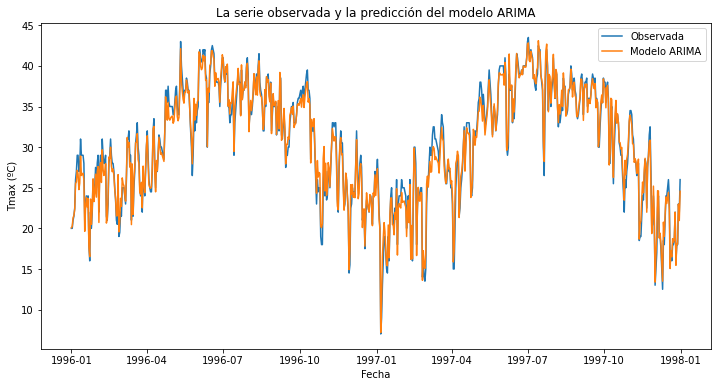

In [35]:
ts_test_last = ts_test.tail(730)
predictions_ARIMA_last = predictions_ARIMA.tail(730)
plt.plot(ts_test_last, label='Observada');
plt.plot(predictions_ARIMA_last, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');

In [52]:
start, end = '1995-01', '1999-01'

ts_90 = df_90.loc[start:end].copy()
ts_90.head()

,Precip,Evap,Tmax,Tmin,Año,Mes
Fecha,,,,,,
1995-01-01,0.0,NaN,17.5,0.5,1995,Jan
1995-01-02,0.0,NaN,17.5,2.0,1995,Jan
1995-01-03,0.5,NaN,16.5,2.0,1995,Jan
1995-01-04,5.0,NaN,12.0,4.0,1995,Jan
1995-01-05,5.0,NaN,13.0,7.0,1995,Jan


In [53]:
ts_test2 = ts_90['Tmin'].copy()

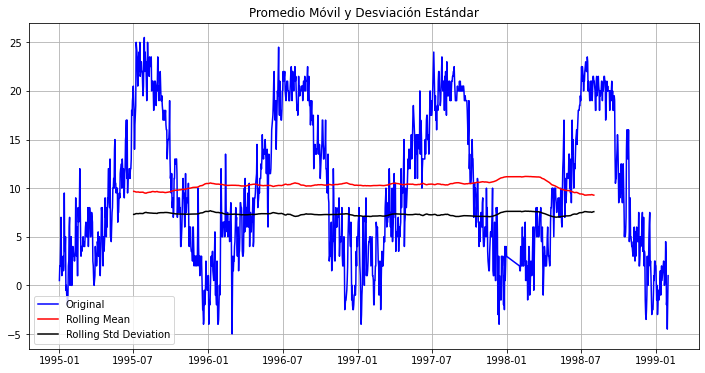

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -2.059838
p-value                           0.260968
#Lags Used                       11.000000
Number of Observations Used    1448.000000
Critical Value (1%)              -3.434874
Critical Value (5%)              -2.863538
Critical Value (10%)             -2.567834
dtype: float64


In [54]:
test_stationarity(ts_test2)

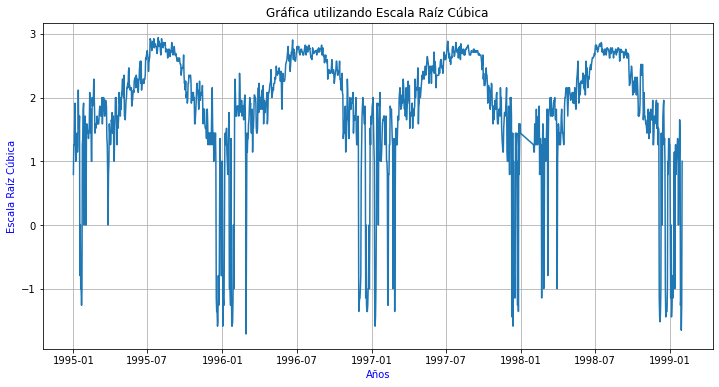

In [59]:
ts_test2_cbrt = np.cbrt(ts_test2)
plt.plot(ts_test2_cbrt)
plt.xlabel('Años',color='b')
plt.ylabel('Escala Raíz Cúbica',color='b')
plt.title('Gráfica utilizando Escala Raíz Cúbica')
plt.grid()
plt.show()

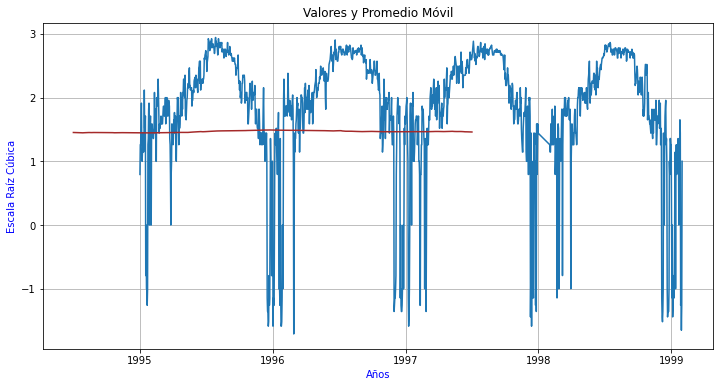

In [60]:
moving2_avg = ts_test2_cbrt.rolling(365, center=True).mean()
plt.plot(ts_test2_cbrt)
plt.plot(moving_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Raíz Cúbica',color='b')
plt.title('Valores y Promedio Móvil')
plt.grid()
plt.show()

In [61]:
ts_test2_cbrt_moving_ave_diff = ts_test2_cbrt - moving_avg 
ts_test2_cbrt_moving_ave_diff.head()

Fecha
1994-01-01   NaN
1994-01-02   NaN
1994-01-03   NaN
1994-01-04   NaN
1994-01-05   NaN
dtype: float64

In [62]:
ts_test2_cbrt_moving_ave_diff.dropna(inplace=True)
ts_test2_cbrt_moving_ave_diff.head()

Fecha
1995-01-01   -0.651953
1995-01-02   -0.185611
1995-01-03   -0.185642
1995-01-04    0.141793
1995-01-05    0.467221
dtype: float64

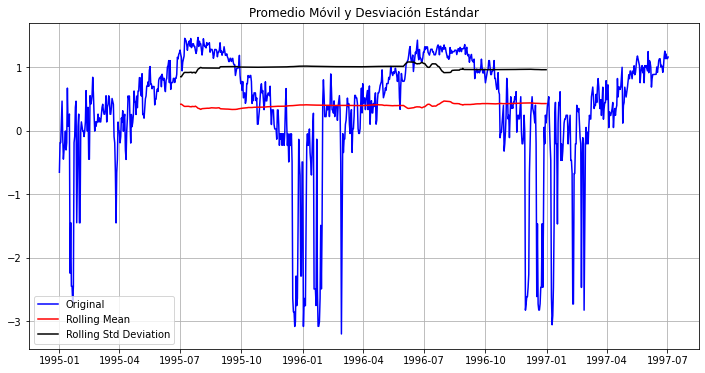

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                  -2.764555
p-value                          0.063518
#Lags Used                      16.000000
Number of Observations Used    896.000000
Critical Value (1%)             -3.437669
Critical Value (5%)             -2.864771
Critical Value (10%)            -2.568490
dtype: float64


In [63]:
test_stationarity(ts_test2_cbrt_moving_ave_diff)

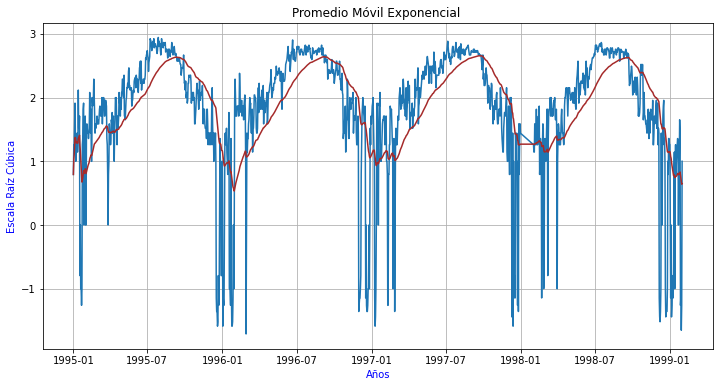

In [64]:
EWM2_avg = ts_test2_cbrt.ewm(halflife=30).mean()
plt.plot(ts_test2_cbrt)
plt.plot(EWM2_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Raíz Cúbica',color='b')
plt.title('Promedio Móvil Exponencial ')
plt.grid()
plt.show()

In [70]:
ts_test2_cbrt_EWM2_avg_diff = ts_test2_cbrt - EWM_avg
EWM2_avg.head()

Fecha
1995-01-01    0.793701
1995-01-02    1.029504
1995-01-03    1.108091
1995-01-04    1.232103
1995-01-05    1.374632
Name: Tmin, dtype: float64

In [71]:
ts_test2_cbrt_EWM2_avg_diff.dropna(inplace=True)

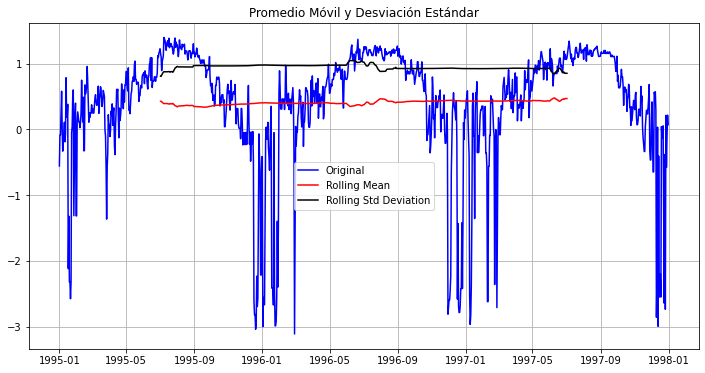

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -2.799188
p-value                           0.058390
#Lags Used                       20.000000
Number of Observations Used    1074.000000
Critical Value (1%)              -3.436453
Critical Value (5%)              -2.864235
Critical Value (10%)             -2.568205
dtype: float64


In [72]:
test_stationarity(ts_test2_cbrt_EWM2_avg_diff)

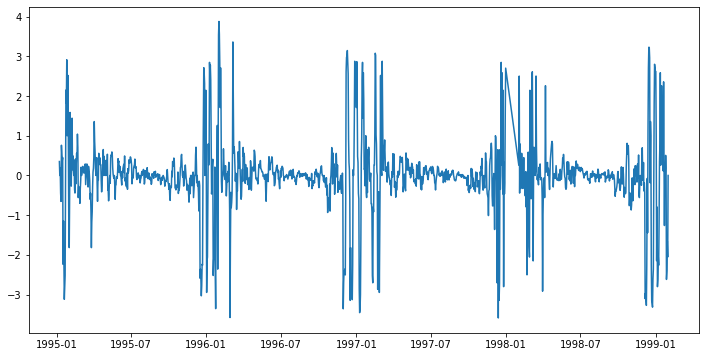

In [73]:
ts_test2_cbrt_diff = ts_test2_cbrt - ts_test2_cbrt.shift(periods=7)
plt.plot(ts_test2_cbrt_diff)

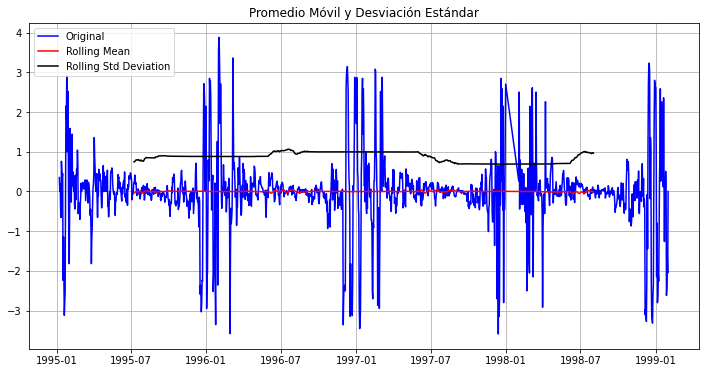

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -9.806114e+00
p-value                        5.820245e-17
#Lags Used                     2.400000e+01
Number of Observations Used    1.428000e+03
Critical Value (1%)           -3.434938e+00
Critical Value (5%)           -2.863566e+00
Critical Value (10%)          -2.567849e+00
dtype: float64


In [74]:
ts_test2_cbrt_diff.dropna(inplace=True)
test_stationarity(ts_test2_cbrt_diff)

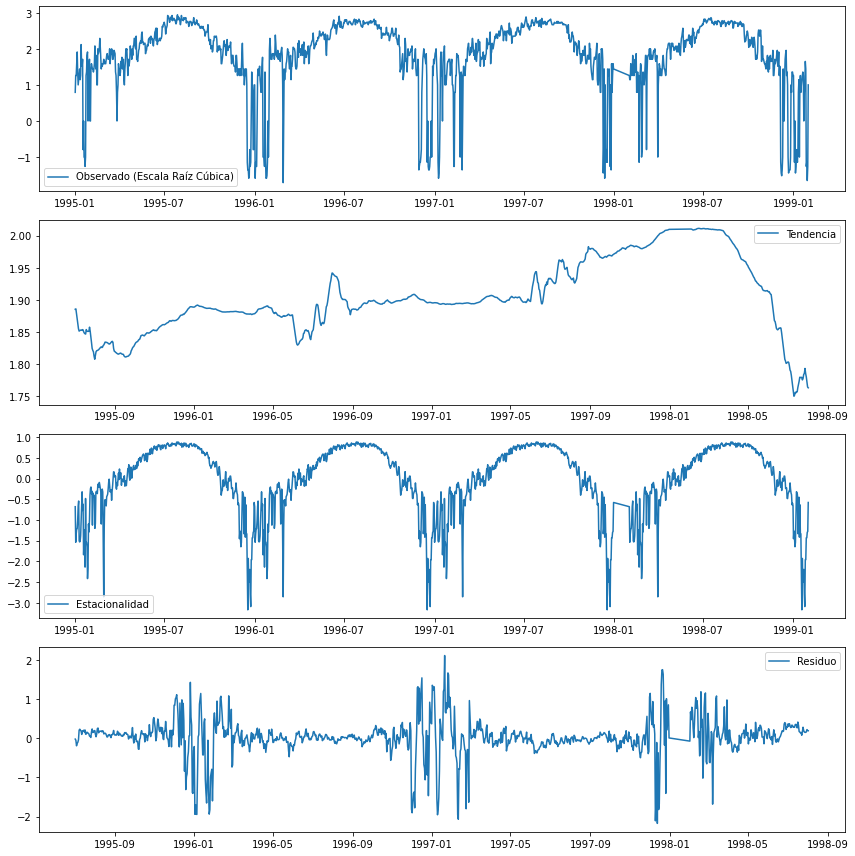

In [76]:
des = sm.tsa.seasonal_decompose(ts_test2_cbrt.interpolate(), model='additive', period=365)


trend = des.trend
seasonal = des.seasonal
residue = des.resid

plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_test2_cbrt, label='Observado (Escala Raíz Cúbica)')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residue, label='Residuo')
plt.legend(loc='best')

plt.tight_layout()

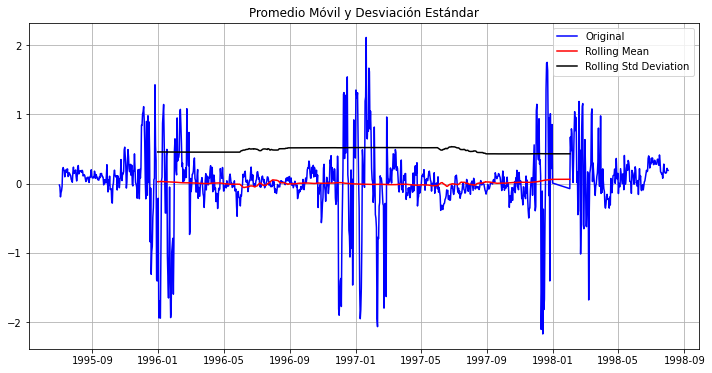

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -6.816715e+00
p-value                        2.050325e-09
#Lags Used                     1.800000e+01
Number of Observations Used    1.077000e+03
Critical Value (1%)           -3.436436e+00
Critical Value (5%)           -2.864227e+00
Critical Value (10%)          -2.568201e+00
dtype: float64


In [77]:
ts_test2_cbrt_decompose = residue 
ts_test2_cbrt_decompose.dropna(inplace=True)
test_stationarity(ts_test2_cbrt_decompose)

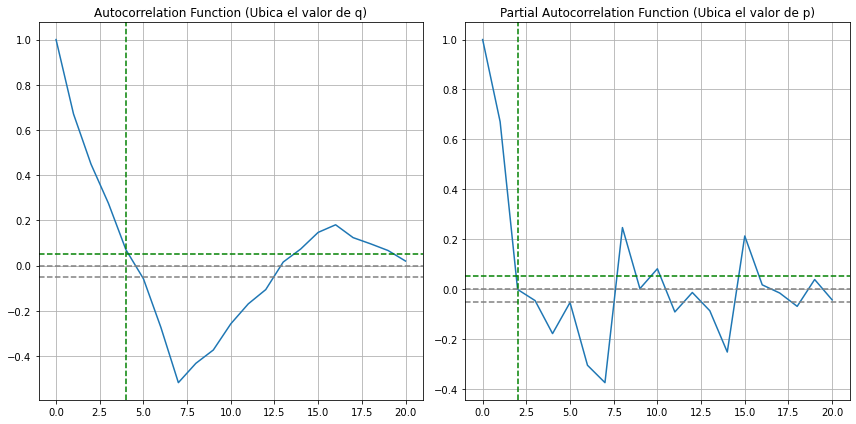

In [78]:
lag_acf = acf(ts_test2_cbrt_diff, nlags=20)
lag_pacf = pacf(ts_test2_cbrt_diff, nlags=20, method = 'ols')

plt.rcParams["figure.figsize"] = (12,6)

plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test2_cbrt_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test2_cbrt_diff)), linestyle='--', color='green')

plt.axvline(x=4, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test2_cbrt_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test2_cbrt_diff)), linestyle='--', color='green')

plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

E:\Python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
E:\Python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmin   No. Observations:                 1459
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -1033.791
Method:                       css-mle   S.D. of innovations              0.491
Date:                Fri, 19 Feb 2021   AIC                           2075.582
Time:                        23:03:59   BIC                           2096.724
Sample:                             1   HQIC                          2083.469
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0004      0.009     -0.039      0.969      -0.019       0.018
ar.L1.D.Tmin    -0.2250      0.026     -8.602      0.000      -0.276      -0.174
ar.L2.D.Tmin    -0.1305      0.026     -4.98

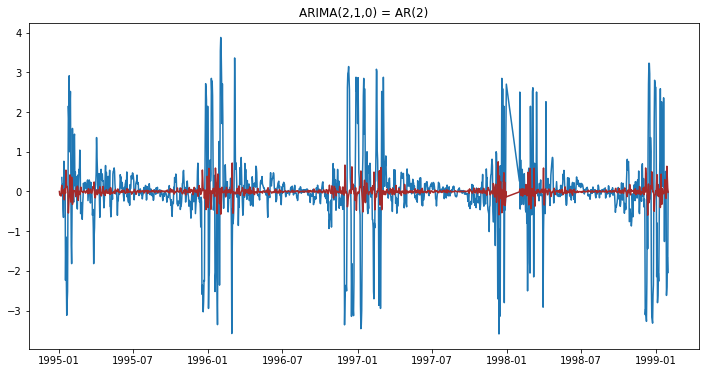

In [79]:
model = ARIMA(ts_test2_cbrt, order=(2,1,0), missing='drop')
results_AR2 = model.fit(displ=-1)
plt.plot(ts_test2_cbrt_diff)
plt.plot(results_AR2.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR2.summary())

E:\Python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
E:\Python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmin   No. Observations:                 1459
Model:                 ARIMA(0, 1, 4)   Log Likelihood                -979.377
Method:                       css-mle   S.D. of innovations              0.473
Date:                Fri, 19 Feb 2021   AIC                           1970.754
Time:                        23:04:24   BIC                           2002.467
Sample:                             1   HQIC                          1982.585
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0006      0.003     -0.197      0.844      -0.006       0.005
ma.L1.D.Tmin    -0.2833      0.026    -10.970      0.000      -0.334      -0.233
ma.L2.D.Tmin    -0.1686      0.026     -6.41

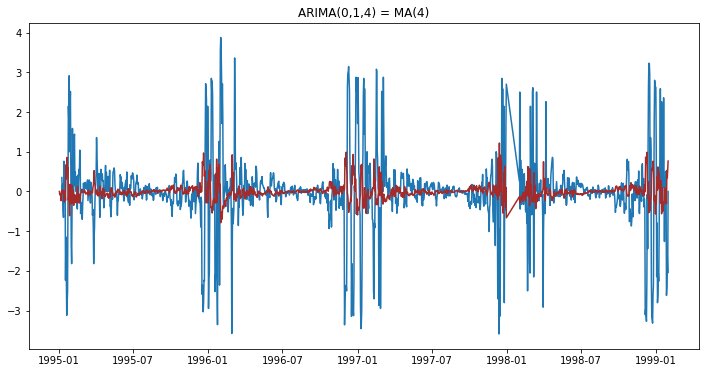

In [80]:
model = ARIMA(ts_test2_cbrt, order=(0,1,4), missing='drop')
results_MA2 = model.fit(displ=-1)
plt.plot(ts_test2_cbrt_diff)
plt.plot(results_MA2.fittedvalues, color='brown')
plt.title('ARIMA(0,1,4) = MA(4)')
print(results_MA2.summary())

E:\Python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
E:\Python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmin   No. Observations:                 1459
Model:                 ARIMA(2, 1, 4)   Log Likelihood                -974.945
Method:                       css-mle   S.D. of innovations              0.472
Date:                Fri, 19 Feb 2021   AIC                           1965.890
Time:                        23:04:54   BIC                           2008.174
Sample:                             1   HQIC                          1981.664
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0005      0.003     -0.199      0.842      -0.006       0.005
ar.L1.D.Tmin     0.0103      0.120      0.086      0.932      -0.225       0.246
ar.L2.D.Tmin     0.3113      0.102      3.05

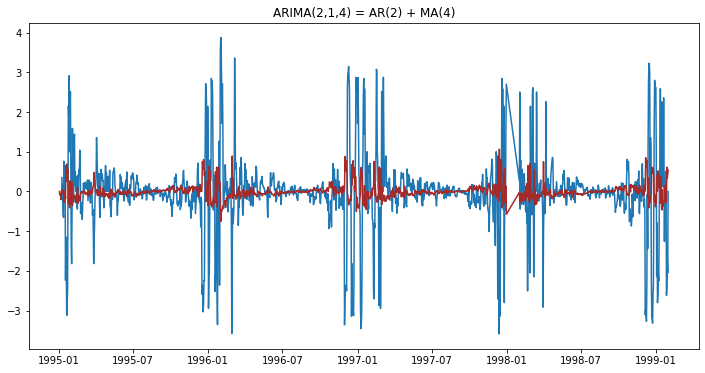

In [81]:
model = ARIMA(ts_test2_cbrt, order=(2,1,4), missing='drop')
results_ARIMA2 = model.fit(displ=-1)
plt.plot(ts_test2_cbrt_diff)
plt.plot(results_ARIMA2.fittedvalues, color='brown')
plt.title('ARIMA(2,1,4) = AR(2) + MA(4)')
print(results_ARIMA2.summary())

In [82]:
predictions2_ARIMA_diff = pd.Series(results_ARIMA2.fittedvalues, copy=True)
print(predictions2_ARIMA_diff)

Fecha
1995-01-02   -0.000512
1995-01-03   -0.088902
1995-01-04   -0.059617
1995-01-05   -0.094805
1995-01-06   -0.204963
                ...   
1999-01-27   -0.270480
1999-01-28    0.610577
1999-01-29    0.328131
1999-01-30    0.438892
1999-01-31    0.539774
Length: 1459, dtype: float64


In [83]:
predictions2_ARIMA_cbrt = pd.Series(ts_test2_cbrt, index = ts_test2_cbrt.index)
predictions2_ARIMA_cbrt = predictions2_ARIMA_cbrt.add(predictions2_ARIMA_diff)
print(predictions2_ARIMA_cbrt.head())
print(predictions2_ARIMA_cbrt.tail())

Fecha
1995-01-01         NaN
1995-01-02    1.259409
1995-01-03    1.171019
1995-01-04    1.527784
1995-01-05    1.818126
dtype: float64
Fecha
1999-01-27   -1.530401
1999-01-28   -0.534138
1999-01-29   -1.322833
1999-01-30   -0.821029
1999-01-31    1.539774
dtype: float64


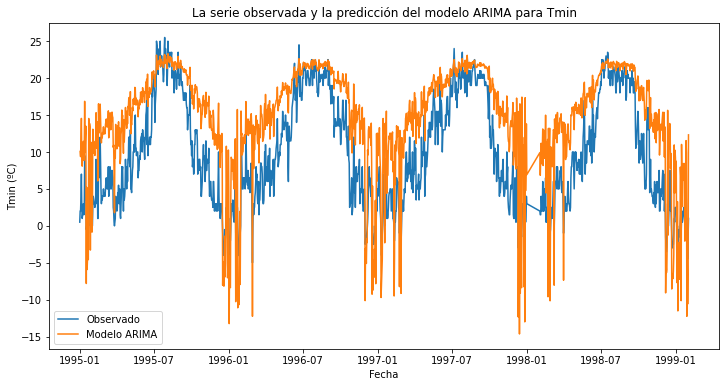

In [107]:
predictions2_ARIMA = 8*(predictions2_ARIMA_cbrt)

plt.rcParams["figure.figsize"] = (12,6)

plt.plot(ts_test2, label='Observado');
plt.plot(predictions2_ARIMA, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmin (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA para Tmin')
plt.legend(loc='best')

In [108]:
RMSE = np.sqrt(np.mean((predictions2_ARIMA - ts_test2)))
print('RMSE:', RMSE)

RMSE: 2.225579104988734


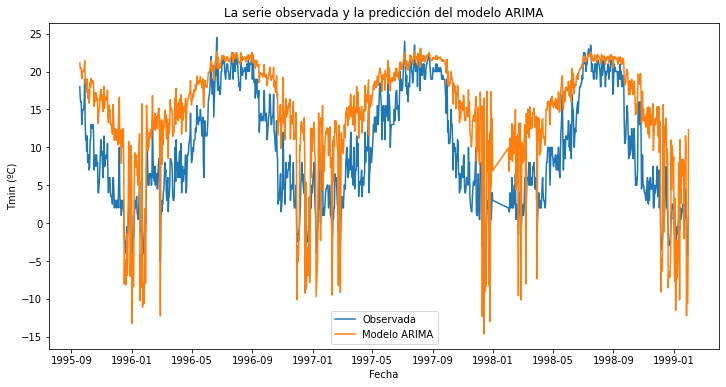

In [109]:
ts_test2_last = ts_test2.tail(1200)
predictions2_ARIMA_last = predictions2_ARIMA.tail(1200)
plt.plot(ts_test2_last, label='Observada');
plt.plot(predictions2_ARIMA_last, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmin (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best')